# Movie Recommendation Model

In [1]:
# import dependencies
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler

In [2]:
# disable chained assignments
pd.options.mode.chained_assignment = None 

In [3]:
# import csv
credits = pd.read_csv('tmdb_5000_credits.csv')
movies = pd.read_csv('tmdb_5000_movies.csv')

# merge into a single Dataframe
mergedDataFrame = credits.merge(movies, on='title')

In [4]:
mergedDataFrame.head(2)

,movie_id,title,cast,crew,budget,genres,homepage,id,keywords,original_language,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,...,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500


In [5]:
# column name
mergedDataFrame.columns

Index(['movie_id', 'title', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'id', 'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'vote_average', 'vote_count'],
      dtype='object')

In [6]:
# number of Na values in each column
mergedDataFrame.isna().sum()

movie_id                   0
title                      0
cast                       0
crew                       0
budget                     0
genres                     0
homepage                3096
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
vote_average               0
vote_count                 0
dtype: int64

In [7]:
# movie Ids Series
movieIds = mergedDataFrame['movie_id']

### Vector Data Frame

In [8]:
# create vectorsDataFrame with relavent series
vectorsDataFrame = mergedDataFrame[[ 
    'title',      
    'original_language', 
    'production_companies', 'production_countries', 
    'overview',
    'genres','keywords',
    'cast','crew']]
vectorsDataFrame.head(2)

,title,original_language,production_companies,production_countries,overview,genres,keywords,cast,crew
0,Avatar,en,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,Pirates of the Caribbean: At World's End,en,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [9]:
# Function that parses through the json string 
# and fetches the desired parameters
def jsonParser(obj, parameter): 
    List = list(map(lambda y: str(y[parameter])
            .replace(' ', '_'), json.loads(obj)))
    return List

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [11]:
# Fuction that plots the unique value
def dataPlot(series, label):
    # flatten the array of array of strings to a 1D array
    flat_series = np.concatenate(series)

    # count the frequency of each item in the flattened array
    series_counts = Counter(flat_series)
    print(series_counts)
    
    plt.figure(figsize=(25, 4))
    plt.plot(series_counts.keys(),series_counts.values())

    plt.xlabel('Count')
    plt.ylabel('Number of Unique ' + label)
    plt.title('Histogram of Unique ' + label)

    plt.show()

In [12]:
# Fetching first 5 names of cast
vectorsDataFrame.cast = \
    vectorsDataFrame.cast.apply(lambda x: jsonParser(x, 'name')[:5])

vectorsDataFrame.cast.head(2)

0    [Sam_Worthington, Zoe_Saldana, Sigourney_Weave...
1    [Johnny_Depp, Orlando_Bloom, Keira_Knightley, ...
Name: cast, dtype: object

In [13]:
# Fetching names of genres
vectorsDataFrame.genres = \
    vectorsDataFrame.genres.apply(lambda x: jsonParser(x, 'name')[:5])

vectorsDataFrame.genres.head(2)

0    [Action, Adventure, Fantasy, Science_Fiction]
1                     [Adventure, Fantasy, Action]
Name: genres, dtype: object

Counter({'Drama': 2300, 'Comedy': 1723, 'Thriller': 1260, 'Action': 1155, 'Romance': 891, 'Adventure': 792, 'Crime': 697, 'Science_Fiction': 533, 'Horror': 520, 'Family': 511, 'Fantasy': 419, 'Mystery': 347, 'Animation': 234, 'History': 197, 'Music': 183, 'War': 142, 'Documentary': 110, 'Western': 80, 'Foreign': 34, 'TV_Movie': 8})


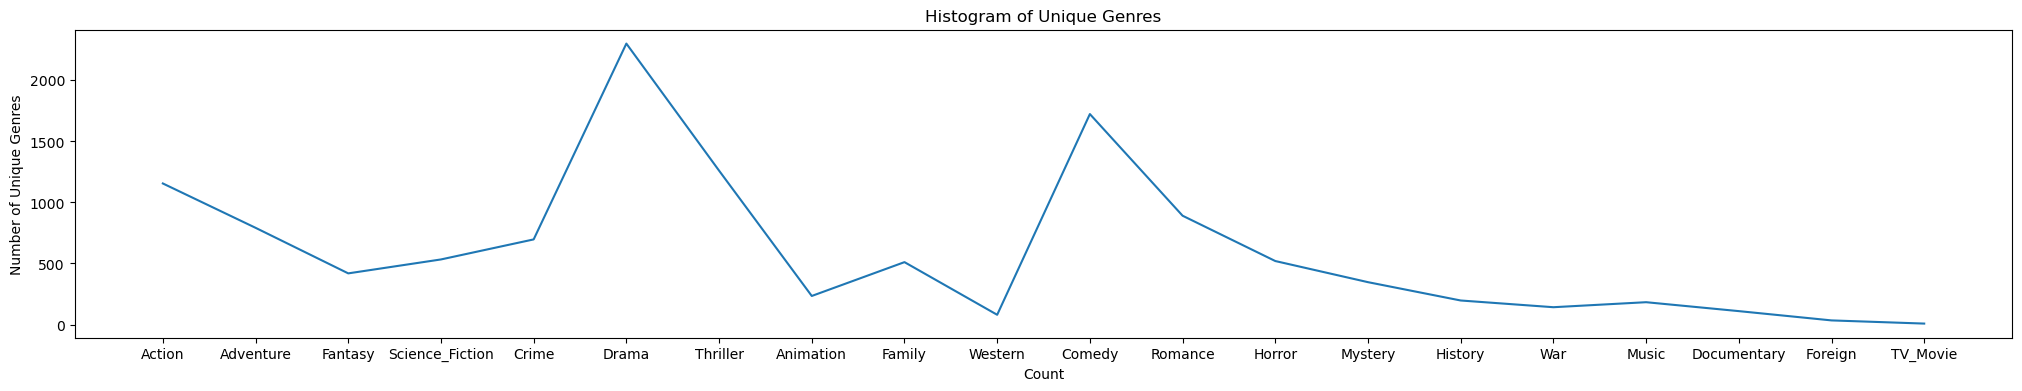

In [14]:
dataPlot(vectorsDataFrame.genres, 'Genres')

In [15]:
# Fetching names of keywords
vectorsDataFrame.keywords = \
    vectorsDataFrame.keywords.apply(lambda x: jsonParser(x, 'name')[:5])
vectorsDataFrame.keywords.head(2)

0    [culture_clash, future, space_war, space_colon...
1    [ocean, drug_abuse, exotic_island, east_india_...
Name: keywords, dtype: object

In [16]:
# Fetching names of production companies
vectorsDataFrame.production_companies = \
    vectorsDataFrame.production_companies \
        .apply(lambda x: jsonParser(x, 'name')[:5])
    
vectorsDataFrame.production_companies.head(2)

0    [Ingenious_Film_Partners, Twentieth_Century_Fo...
1    [Walt_Disney_Pictures, Jerry_Bruckheimer_Films...
Name: production_companies, dtype: object

In [17]:
# Fetching names of production countries
vectorsDataFrame.production_countries = \
    vectorsDataFrame.production_countries \
        .apply(lambda x: jsonParser(x, 'name'))
vectorsDataFrame.production_countries.head(2)

0    [United_States_of_America, United_Kingdom]
1                    [United_States_of_America]
Name: production_countries, dtype: object

Counter({'United_States_of_America': 3959, 'United_Kingdom': 637, 'Germany': 324, 'France': 306, 'Canada': 262, 'Australia': 110, 'Italy': 72, 'Spain': 71, 'China': 59, 'Japan': 58, 'India': 54, 'Hong_Kong': 48, 'Ireland': 37, 'Mexico': 30, 'New_Zealand': 29, 'Belgium': 25, 'Czech_Republic': 24, 'South_Africa': 20, 'Denmark': 20, 'Sweden': 19, 'Russia': 19, 'Switzerland': 19, 'South_Korea': 19, 'Netherlands': 18, 'United_Arab_Emirates': 14, 'Norway': 14, 'Hungary': 13, 'Brazil': 13, 'Romania': 12, 'Luxembourg': 11, 'Argentina': 9, 'Poland': 6, 'Iceland': 6, 'Austria': 6, 'Thailand': 6, 'Israel': 6, 'Taiwan': 5, 'Finland': 5, 'Bahamas': 4, 'Malta': 4, 'Morocco': 4, 'Bulgaria': 4, 'Iran': 4, 'Pakistan': 3, 'Greece': 3, 'Jamaica': 2, 'Slovenia': 2, 'Singapore': 2, 'Malaysia': 2, 'Peru': 2, 'Kazakhstan': 2, 'Chile': 2, 'Slovakia': 2, 'Colombia': 2, 'Dominica': 1, 'Monaco': 1, 'Tunisia': 1, 'Philippines': 1, 'Bosnia_and_Herzegovina': 1, 'Portugal': 1, 'Aruba': 1, 'Libyan_Arab_Jamahiriya': 1

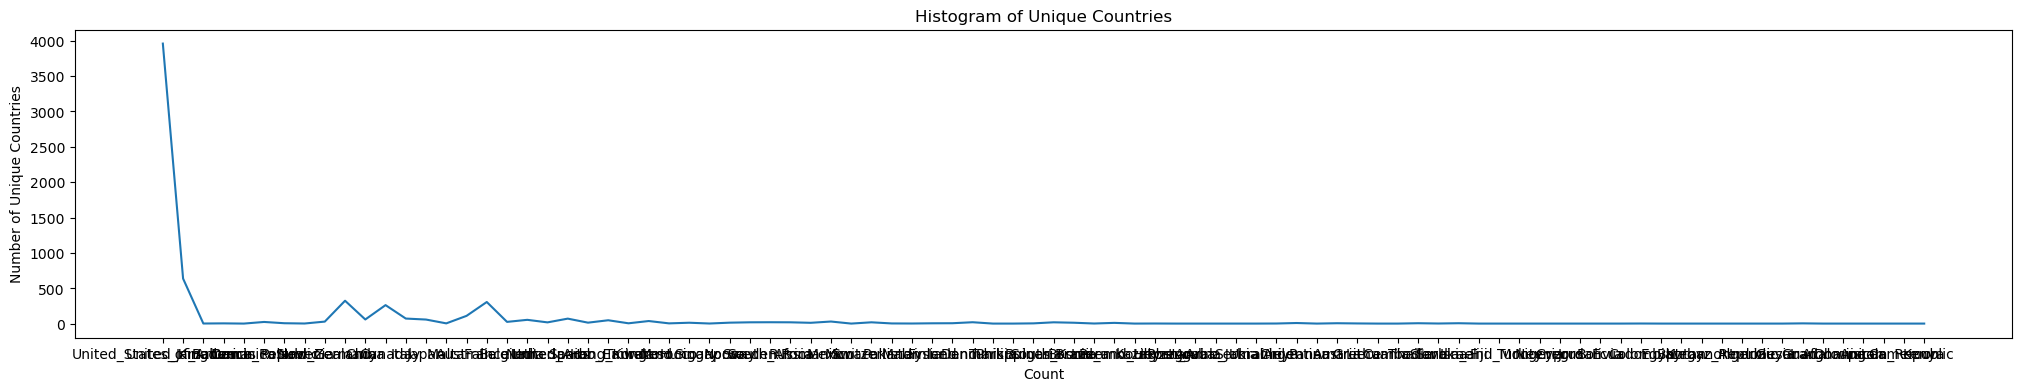

In [18]:
dataPlot(vectorsDataFrame.production_countries, 'Countries')

In [19]:
# convert original language to list
vectorsDataFrame.original_language = \
    vectorsDataFrame.original_language.apply(lambda x: [x])

vectorsDataFrame.original_language.head(2)

0    [en]
1    [en]
Name: original_language, dtype: object

Counter({'en': 4510, 'fr': 70, 'es': 32, 'zh': 27, 'de': 27, 'hi': 19, 'ja': 16, 'it': 14, 'ko': 12, 'cn': 12, 'ru': 11, 'pt': 9, 'da': 7, 'sv': 5, 'nl': 4, 'fa': 4, 'th': 3, 'he': 3, 'ta': 2, 'cs': 2, 'ar': 2, 'id': 2, 'ro': 2, 'te': 1, 'xx': 1, 'hu': 1, 'is': 1, 'tr': 1, 'nb': 1, 'af': 1, 'pl': 1, 'vi': 1, 'ky': 1, 'no': 1, 'sl': 1, 'ps': 1, 'el': 1})


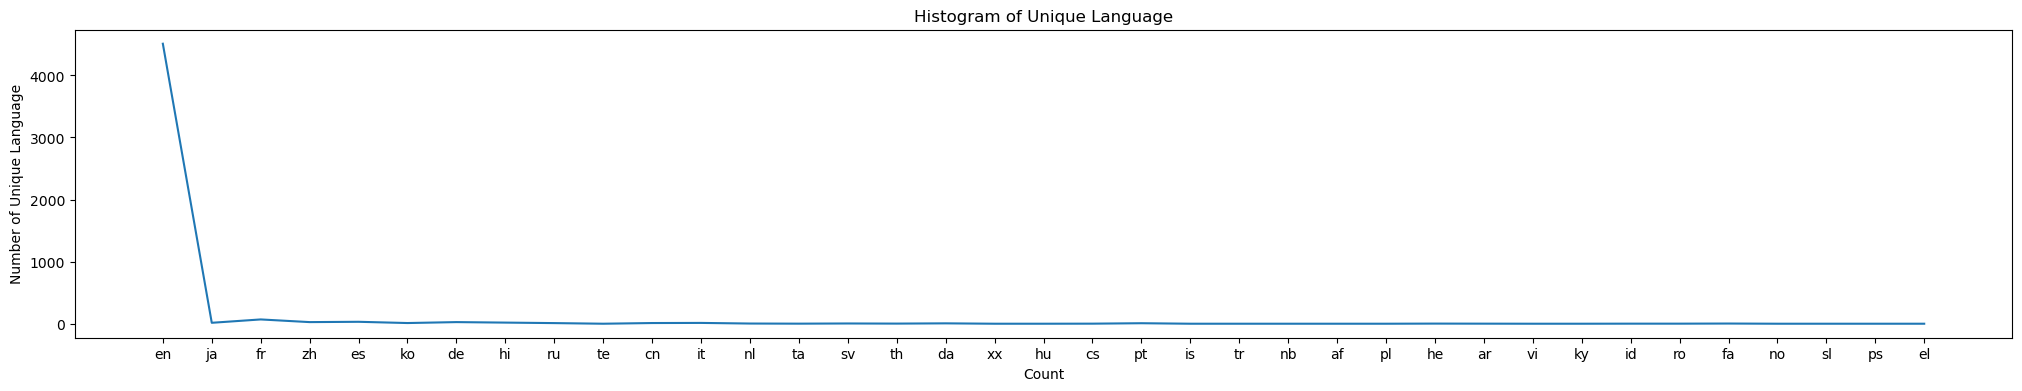

In [20]:
dataPlot(vectorsDataFrame.original_language, 'Language')

In [21]:
# fetch names of writers and directors
def getCrew(obj):
    crewname = dict({'Director': [], 'Writer': []})
    crew_object = json.loads(obj)
    for crew in crew_object:
        if not crew['job'] in crewname.keys():
            continue
        crewname[crew['job']].append(str(crew['name']).replace(' ', '_'))
    return [crewname['Director'], crewname['Writer']]

In [22]:
crew = vectorsDataFrame.crew.apply(lambda x: getCrew(x))

vectorsDataFrame['Director'] = crew.apply(lambda x: list(set(x[0] + x[1])))

vectorsDataFrame.drop(['crew'], axis='columns', inplace=True)

In [23]:
vectorsDataFrame['overview'] = \
    vectorsDataFrame.overview.apply(lambda x: str(x).split())

In [24]:
vectorsDataFrame.head(2)

,title,original_language,production_companies,production_countries,overview,genres,keywords,cast,Director
0,Avatar,[en],"[Ingenious_Film_Partners, Twentieth_Century_Fo...","[United_States_of_America, United_Kingdom]","[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science_Fiction]","[culture_clash, future, space_war, space_colon...","[Sam_Worthington, Zoe_Saldana, Sigourney_Weave...",[James_Cameron]
1,Pirates of the Caribbean: At World's End,[en],"[Walt_Disney_Pictures, Jerry_Bruckheimer_Films...",[United_States_of_America],"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drug_abuse, exotic_island, east_india_...","[Johnny_Depp, Orlando_Bloom, Keira_Knightley, ...",[Gore_Verbinski]


In [25]:
vectorsDataFrame['tags'] = \
    vectorsDataFrame['original_language'] + \
    vectorsDataFrame['production_companies'] + \
    vectorsDataFrame['production_countries'] + \
    vectorsDataFrame['overview'] + \
    vectorsDataFrame['genres'] + vectorsDataFrame['keywords'] + \
    vectorsDataFrame['cast'] + vectorsDataFrame['Director']

In [26]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [27]:
# steming
vectorsDataFrame['tags'] = \
    vectorsDataFrame['tags'].apply(lambda x: list(map(ps.stem, x)))

In [28]:
vectorsDataFrame['tags'] = \
    vectorsDataFrame['tags'].apply(lambda x: ' '.join(x).lower())

In [29]:
vectorsDataFrame \
    .drop(columns=['original_language', 
                   'production_companies', 'production_countries', 
                   'overview',
                   'genres','keywords',
                   'cast', 'Director'], inplace= True)

vectorsDataFrame.head(2)

,title,tags
0,Avatar,en ingenious_film_partn twentieth_century_fox_...
1,Pirates of the Caribbean: At World's End,en walt_disney_pictur jerry_bruckheimer_film s...


### Merge

In [30]:
DataFrame = pd.DataFrame()
DataFrame['movie_id'] = movieIds
DataFrame = pd.concat([DataFrame, vectorsDataFrame], axis='columns')

DataFrame.head()

,movie_id,title,tags
0,19995,Avatar,en ingenious_film_partn twentieth_century_fox_...
1,285,Pirates of the Caribbean: At World's End,en walt_disney_pictur jerry_bruckheimer_film s...
2,206647,Spectre,en columbia_pictur danjaq b24 united_kingdom u...
3,49026,The Dark Knight Rises,en legendary_pictur warner_bros. dc_entertain ...
4,49529,John Carter,en walt_disney_pictur united_states_of_america...


In [31]:
# save the ouput
DataFrame.to_csv('output/movies_dataframe.csv')

### Vectorization

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,stop_words='english')

In [33]:
vector = cv.fit_transform(DataFrame['tags']).toarray()

In [34]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

In [35]:
similarity = cosine_similarity(vector)

In [36]:
# Getting the most related movies
def getMostRelated(obj):
    sortedlist = sorted( \
        list(enumerate(obj)), \
        reverse=True,key = lambda x: x[1])[1:31]
    
    return list(map(lambda x: x[0] ,sortedlist))

In [37]:
similarity = list(map(lambda x: getMostRelated(x) ,similarity.tolist()))

## Recommendations

In [38]:
# recommendation function
def recommend(movie):
    index = DataFrame[DataFrame['title'] == movie].index[0]
    distances = similarity[index]
    print(f'{"Recommendations":.^41}')
    for i in distances[:6]:
        print(DataFrame.iloc[i].title)

In [39]:
recommend('The Dark Knight Rises')

.............Recommendations.............
The Dark Knight
Batman Begins
Batman
Batman Forever
Batman
Nighthawks


In [40]:
recommend('Spectre')

.............Recommendations.............
Skyfall
Quantum of Solace
Never Say Never Again
Diamonds Are Forever
From Russia with Love
On Her Majesty's Secret Service


In [41]:
recommend('8 Mile')

.............Recommendations.............
Hustle & Flow
Tupac: Resurrection
You Got Served
Blue Like Jazz
I Origins
We Are Your Friends


### storing similarity data 

In [42]:
import joblib

In [43]:
joblib.dump(similarity, 'output/similarity')

['output/similarity']